In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from keras.preprocessing import image
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16

import os.path
import cv2
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D

/home/rajivratn/debanjan/softwares/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:33: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
vgg_base = VGG16(include_top=False, weights='imagenet')

In [4]:
vgg_base.layers

In [6]:
# you can set how many layer you want to train
# i am training last 4 convolutinal layers

for layer in vgg_base.layers:
    layer.trainable = False
    
for layer in vgg_base.layers[-4:]:
    layer.trainable = True

in case if we don't want to train last 4 convolutional layers, we can remove the -4 layer and set all layers as **trainable=false**

In [7]:
# add a global spatial average pooling layer
x = vgg_base.output
x = GlobalAveragePooling2D()(x)
# add a fully-connected layer
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
# and a fully connected output/classification layer
predictions = Dense(12, activation='softmax')(x)
# create the full network so we can train on it
vgg_transfer = Model(input=vgg_base.input, output=predictions)
vgg_transfer.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/home/rajivratn/debanjan/softwares/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # This is added back by InteractiveShellApp.init_path()


In [8]:
vgg_transfer.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

as we can see, we can set last 4 convolution layer of the model as trainable

and dense layer are by default trainable

as per requirement, we can train only on dense layers and set all convolution layers as non-trainable

### Starting with dataset

In [10]:
import glob

count = 0;
X_filename=[];
y_classname= [];
for filename in sorted(glob.iglob('train/**/', recursive=False)):
    localNumber = 0
    for insideFile in sorted(glob.iglob(filename+"*.png", recursive=False)):
        X_filename.append(insideFile);
        y_classname.append(count);
        localNumber += 1
        
    print(filename+" -- "+str(localNumber))
    count = count + 1;

train/Black-grass/ -- 263
train/Charlock/ -- 390
train/Cleavers/ -- 287
train/Common Chickweed/ -- 611
train/Common wheat/ -- 221
train/Fat Hen/ -- 475
train/Loose Silky-bent/ -- 654
train/Maize/ -- 221
train/Scentless Mayweed/ -- 516
train/Shepherds Purse/ -- 231
train/Small-flowered Cranesbill/ -- 496
train/Sugar beet/ -- 385


In [17]:
all_classes = ['train/Cleavers/',
'train/Sugar beet/',
'train/Common Chickweed/',
'train/Loose Silky-bent/',
'train/Scentless Mayweed/',
'train/Shepherds Purse/',
'train/Fat Hen/',
'train/Common wheat/',
'train/Black-grass/',
'train/Small-flowered Cranesbill/',
'train/Charlock/',
'train/Maize/']

all_classes = sort(all_classes)

In [18]:
all_classes

array(['train/Black-grass/', 'train/Charlock/', 'train/Cleavers/',
       'train/Common Chickweed/', 'train/Common wheat/', 'train/Fat Hen/',
       'train/Loose Silky-bent/', 'train/Maize/',
       'train/Scentless Mayweed/', 'train/Shepherds Purse/',
       'train/Small-flowered Cranesbill/', 'train/Sugar beet/'],
      dtype='<U32')

In [20]:
def preprocessing(image):
    
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    output = cv2.bitwise_and(image, image, mask = mask)

    output_blurred = cv2.GaussianBlur(output, (5, 5), 3)
    #output_sharp1 = cv2.addWeighted(output, 2.5, output_blurred, -0.5, 0)
    #crop_image1 = findBoundingBox(mask, output_sharp1)
    
    #output_sharp2 = cv2.addWeighted(output, 2, output_blurred, -0.5, 0)
    #crop_image2 = findBoundingBox(mask, output_sharp2)
    
    output_sharp = cv2.addWeighted(output, 1.5, output_blurred, -0.5, 0)
    #crop_image = findBoundingBox(mask, output_sharp)

    #output_sharp4 = cv2.addWeighted(output, 1, output_blurred, -0.5, 0)
    #crop_image4 = findBoundingBox(mask, output_sharp4)
    
    #fig, axs = plt.subplots(1, 4, figsize=(20, 20))
    #axs[0].imshow(image)
    #axs[1].imshow(mask)
    #axs[1].imshow(output)
    #axs[2].imshow(output_sharp)
    #axs[3].imshow(crop_image)

    #return [crop_image1, crop_image2, crop_image3, crop_image4]
    return output_sharp, mask

In [22]:
orgImage = cv2.imread(X_filename[1187], cv2.IMREAD_COLOR)
outImage, maskImage = preprocessing(orgImage)

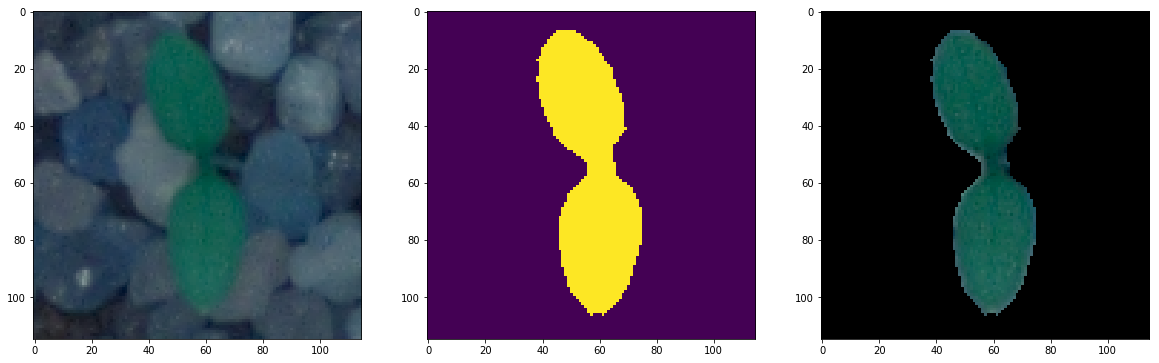

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(20, 20))
axs[0].imshow(orgImage)
axs[1].imshow(maskImage)
axs[2].imshow(outImage)

# splitting data into training and testing

In [27]:
from sklearn.model_selection import train_test_split

train_filename, val_filename = train_test_split(X_filename, test_size=0.1)

In [28]:
print(len(X_filename))
print(len(train_filename))
print(len(val_filename))

4750
4275
475


# fitting binarizer

In [33]:
from sklearn.preprocessing import LabelBinarizer

myBinarizer = LabelBinarizer()
myBinarizer.fit(all_classes)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

# reading all the files before for easy access

In [34]:
def valLoadFile(features):
    X_feature = np.empty([len(features), 449, 449, 3])
    y_feature = np.zeros([len(features), 12])
    
    for i in range(len(features)):
        if(os.path.exists(features[i])):
            imgLoaded = cv2.imread(features[i], cv2.IMREAD_COLOR)#image.load_img(row, target_size=(299,299))
            out, msk = preprocessing(imgLoaded)
            X_feature[i] = image.img_to_array(cv2.resize(out, (449, 449))) / 255
        
        y_fix = np.zeros((12))
        for cls in range(len(all_classes)):
            if(features[i].startswith(all_classes[cls])):
                y_fix = myBinarizer.transform([all_classes[cls]])
                break
        y_feature[i] = y_fix
        
        if i%100 == 0:
            print(str(i)+" done")
    
    print("all done")
    return X_feature, y_feature

In [36]:
X_train, y_train = valLoadFile(train_filename)

0 done
100 done
200 done
300 done
400 done
500 done
600 done
700 done
800 done
900 done
1000 done
1100 done
1200 done
1300 done
1400 done
1500 done
1600 done
1700 done
1800 done
1900 done
2000 done
2100 done
2200 done
2300 done
2400 done
2500 done
2600 done
2700 done
2800 done
2900 done
3000 done
3100 done
3200 done
3300 done
3400 done
3500 done
3600 done
3700 done
3800 done
3900 done
4000 done
4100 done
4200 done
all done


In [37]:
X_validation, y_validation = valLoadFile(val_filename)

0 done
100 done
200 done
300 done
400 done
all done


# Generator for Training

we can use create either our own generator or use keras ImageDataGenerator

In [38]:
from keras.preprocessing.image import ImageDataGenerator

In [39]:
datagenerator = ImageDataGenerator( rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                             zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

In [41]:
#inception_transfer.fit_generator(my_generator(inc_X_train), samples_per_epoch=200, nb_epoch=30)
vgg_transfer.fit_generator(datagenerator.flow(X_train, y_train, batch_size=32), steps_per_epoch=len(X_train) / 32, epochs=20)

Epoch 1/20
  1/133 [..............................] - ETA: 1:17:15 - loss: 2.6052 - acc: 0.0625

KeyboardInterrupt: 

prediction

In [ ]:
predVal = (vgg_transfer.predict(X_validation))

In [ ]:
def checkAccuracy(output_val, val_label):
    totalCount = len(output_val)
    out_local = np.argmax(output_val, axis=1)
    val_local = np.argmax(val_label, axis=1)

    compareResult = (out_local == val_local)
    correctCount = len(compareResult[compareResult == True])
    print(correctCount)
    print(totalCount)
    
    return (correctCount/totalCount)

In [ ]:
checkAccuracy(predVal, y_validation)